# DAE (non recurrent) on Melted data 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# -*- coding: utf-8 -*-
import dataiku
from dataiku import pandasutils as pdu

# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from tensorflow import set_random_seed
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, BatchNormalization
from keras.models import Model
from keras import regularizers

import warnings
warnings.filterwarnings('ignore')

/data/dataiku/dss_data/code-envs/python/DeepL/lib64/python3.6/site-packages/tensorflow_core/core/framework/tensor_shape_pb2.py:23: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  serialized_pb=_b('\n,tensorflow/core/framework/tensor_shape.proto\x12\ntensorflow\"z\n\x10TensorShapeProto\x12-\n\x03\x64im\x18\x02 \x03(\x0b\x32 .tensorflow.TensorShapeProto.Dim\x12\x14\n\x0cunknown_rank\x18\x03 \x01(\x08\x1a!\n\x03\x44im\x12\x0c\n\x04size\x18\x01 \x01(\x03\x12\x0c\n\x04name\x18\x02 \x01(\tBq\n\x18org.tensorflow.frameworkB\x11TensorShapeProtosP\x01Z=github.com/tensorflow/tensorflow/tensorflow/go/core/framework\xf8\x01\x01\x62\x06proto3')
/data/dataiku/dss_data/code-envs/python/DeepL/lib64/python3.6/site-packages/tensorflow_core/core/framework/tensor_shape_pb2.py:42: DeprecationWarning: Call to deprecated create function FieldDescri

Using TensorFlow backend.


In [3]:
# Read recipe inputs
Train_KM4 = dataiku.Dataset("KM4_Melted_windows")
df = Train_KM4.get_dataframe()

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by="Date")
df = df.set_index('Date')
df = df[['value',
         'variable',
         'Machine',
         'value_lag1',
         'value_lag2',
         'value_lag3'
         #'PRESSION REFOULEMENT',
         #'PRESSION ASPIRATION' #,'PALIER EN COURS C2']]
        ]]
df = df.dropna()
#df = df.drop_duplicates()

In [5]:
df_dum = pd.get_dummies(data=df, columns=['variable', 'Machine']) #, 'PALIER EN COURS C2'])
df_dum.shape

(130317, 10)

In [6]:
train, valid, test = df_dum.loc[df_dum.index <= '2022-06-20'], df_dum.loc[(df_dum.index > '2022-06-20') & (df_dum.index <= '2022-07-01')], df_dum.loc[df_dum.index > '2022-07-01']
#valid = train.sample(frac=0.1, random_state=42)
#train = train.drop(valid.index)
train = train.drop_duplicates()

train.shape, test.shape, valid.shape

((87396, 10), (19807, 10), (14730, 10))

In [7]:
valid

,value,value_lag1,value_lag2,value_lag3,variable_VIBRATIONS CYLINDRES 1 CPC2,variable_VIBRATIONS CYLINDRES 2 CPC2,variable_VIBRATIONS CYLINDRES 3 CPC2,variable_VIBRATIONS CYLINDRES 4 CPC2,Machine_KM41,Machine_KM42
Date,,,,,,,,,,
2022-06-20 00:04:28+00:00,11.676329,10.000000,10.000000,10.000000,0,0,1,0,1,0
2022-06-20 00:04:28+00:00,6.530499,7.000000,6.010712,6.860599,1,0,0,0,1,0
2022-06-20 00:04:28+00:00,11.752949,11.000000,11.703794,11.948676,0,1,0,0,1,0
2022-06-20 00:04:36+00:00,9.000000,10.000000,10.000000,9.202370,1,0,0,0,0,1
2022-06-20 00:04:36+00:00,17.680210,19.618149,17.648550,18.203718,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
2022-06-30 23:54:28+00:00,10.086043,10.231244,11.000712,11.138373,0,0,1,0,1,0
2022-06-30 23:59:28+00:00,10.993885,13.000000,11.271657,10.606325,0,1,0,0,1,0
2022-06-30 23:59:28+00:00,11.000000,11.000000,11.000000,11.000000,0,0,0,1,1,0


In [8]:
# normalize the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
valid_scaled = scaler.transform(valid)

train_scaled.shape, test_scaled.shape, valid_scaled.shape

((87396, 10), (19807, 10), (14730, 10))

## Modeling

In [9]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, activation="selu", kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(32, activation="selu", kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(8, activation="selu", kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(4, activation="selu", kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(8, activation="selu", kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(32, activation="selu", kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(64, activation="selu", kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="relu"))

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, mode="min")

model.compile(optimizer='adam', loss="mse")

history = model.fit(train_scaled, train_scaled, epochs=100, batch_size=64,
                    validation_data=(valid_scaled, valid_scaled),
                    shuffle=True,
                    callbacks=[early_stopping]
                    )

Train on 87396 samples, validate on 14730 samples
Epoch 1/100
87396/87396 [==============================] - 3s 40us/sample - loss: 0.0949 - val_loss: 0.0123
Epoch 2/100
87396/87396 [==============================] - 3s 35us/sample - loss: 0.0312 - val_loss: 0.0127
Epoch 3/100
87396/87396 [==============================] - 3s 35us/sample - loss: 0.0230 - val_loss: 0.0119
Epoch 4/100
87396/87396 [==============================] - 3s 35us/sample - loss: 0.0192 - val_loss: 0.0127
Epoch 5/100
87396/87396 [==============================] - 3s 34us/sample - loss: 0.0168 - val_loss: 0.0114
Epoch 6/100
87396/87396 [==============================] - 3s 35us/sample - loss: 0.0155 - val_loss: 0.0111
Epoch 7/100
87396/87396 [==============================] - 3s 34us/sample - loss: 0.0145 - val_loss: 0.0120
Epoch 8/100
87396/87396 [==============================] - 3s 34us/sample - loss: 0.0135 - val_loss: 0.0126
Epoch 9/100
87396/87396 [==============================] - 3s 34us/sample - loss: 0.01

### Training Results

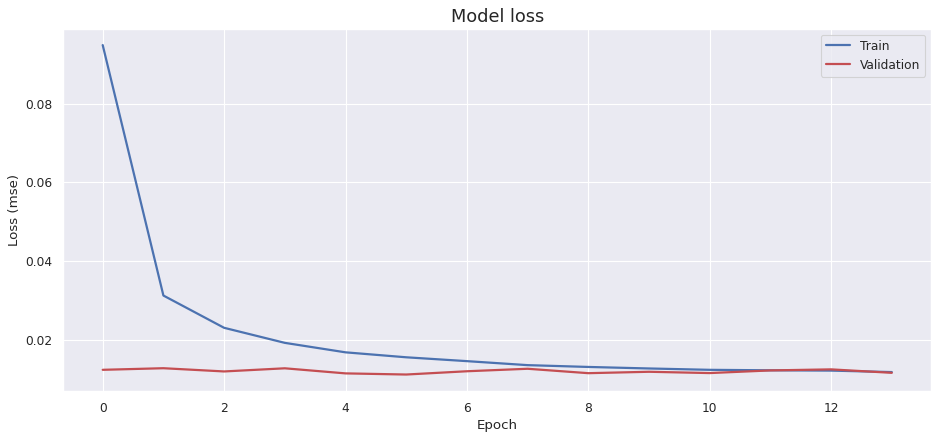

In [11]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mse)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [12]:
reconstructions = model.predict(train_scaled)
train_mae_loss = np.mean(np.abs(reconstructions - train_scaled), axis=1)

In [13]:
#threshold = np.max(train_mae_loss)
threshold = np.mean(train_mae_loss) + 2*np.std(train_mae_loss)
print("Global Reconstruction error threshold: ", threshold)

threshold_KM41 = np.mean(train_mae_loss[train['Machine_KM41'] == 1]) + 2*np.std(train_mae_loss[train['Machine_KM41'] == 1])
print("\nKM41 Reconstruction error threshold: ", threshold_KM41)

threshold_KM42 = np.mean(train_mae_loss[train['Machine_KM42'] == 1]) + 2*np.std(train_mae_loss[train['Machine_KM42'] == 1])
print("KM42 Reconstruction error threshold: ", threshold_KM42)


threshold_KM42_cyl1 = np.mean(train_mae_loss[(train['Machine_KM42'] == 1) & (train['variable_VIBRATIONS CYLINDRES 1 CPC2'] == 1)]) + 2*np.std(train_mae_loss[(train['Machine_KM42'] == 1) & (train['variable_VIBRATIONS CYLINDRES 1 CPC2'] == 1)])
print("\nKM42 Cyl1 Reconstruction error threshold: ", threshold_KM42_cyl1)
threshold_KM42_cyl2 = np.mean(train_mae_loss[(train['Machine_KM42'] == 1) & (train['variable_VIBRATIONS CYLINDRES 2 CPC2'] == 1)]) + 2*np.std(train_mae_loss[(train['Machine_KM42'] == 1) & (train['variable_VIBRATIONS CYLINDRES 2 CPC2'] == 1)])
print("KM42 Cyl2 Reconstruction error threshold: ", threshold_KM42_cyl2)
threshold_KM42_cyl3 = np.mean(train_mae_loss[(train['Machine_KM42'] == 1) & (train['variable_VIBRATIONS CYLINDRES 3 CPC2'] == 1)]) + 2*np.std(train_mae_loss[(train['Machine_KM42'] == 1) & (train['variable_VIBRATIONS CYLINDRES 3 CPC2'] == 1)])
print("KM42 Cyl3 Reconstruction error threshold: ", threshold_KM42_cyl3)
threshold_KM42_cyl4 = np.mean(train_mae_loss[(train['Machine_KM42'] == 1) & (train['variable_VIBRATIONS CYLINDRES 4 CPC2'] == 1)]) + 2*np.std(train_mae_loss[(train['Machine_KM42'] == 1) & (train['variable_VIBRATIONS CYLINDRES 4 CPC2'] == 1)])
print("KM42 Cyl4 Reconstruction error threshold: ", threshold_KM42_cyl4)

threshold_KM41_cyl1 = np.mean(train_mae_loss[(train['Machine_KM41'] == 1) & (train['variable_VIBRATIONS CYLINDRES 1 CPC2'] == 1)]) + 2*np.std(train_mae_loss[(train['Machine_KM41'] == 1) & (train['variable_VIBRATIONS CYLINDRES 1 CPC2'] == 1)])
print("\nKM41 Cyl1 Reconstruction error threshold: ", threshold_KM41_cyl1)
threshold_KM41_cyl2 = np.mean(train_mae_loss[(train['Machine_KM41'] == 1) & (train['variable_VIBRATIONS CYLINDRES 2 CPC2'] == 1)]) + 2*np.std(train_mae_loss[(train['Machine_KM41'] == 1) & (train['variable_VIBRATIONS CYLINDRES 2 CPC2'] == 1)])
print("KM41 Cyl2 Reconstruction error threshold: ", threshold_KM41_cyl2)
threshold_KM41_cyl3 = np.mean(train_mae_loss[(train['Machine_KM41'] == 1) & (train['variable_VIBRATIONS CYLINDRES 3 CPC2'] == 1)]) + 2*np.std(train_mae_loss[(train['Machine_KM41'] == 1) & (train['variable_VIBRATIONS CYLINDRES 3 CPC2'] == 1)])
print("KM41 Cyl3 Reconstruction error threshold: ", threshold_KM41_cyl3)
threshold_KM41_cyl4 = np.mean(train_mae_loss[(train['Machine_KM41'] == 1) & (train['variable_VIBRATIONS CYLINDRES 4 CPC2'] == 1)]) + 2*np.std(train_mae_loss[(train['Machine_KM41'] == 1) & (train['variable_VIBRATIONS CYLINDRES 4 CPC2'] == 1)])
print("KM41 Cyl4 Reconstruction error threshold: ", threshold_KM41_cyl4)

Global Reconstruction error threshold:  0.07991725869848507

KM41 Reconstruction error threshold:  0.09150835995967914
KM42 Reconstruction error threshold:  0.0724455212085992

KM42 Cyl1 Reconstruction error threshold:  0.06482688663670555
KM42 Cyl2 Reconstruction error threshold:  0.07775396223853004
KM42 Cyl3 Reconstruction error threshold:  0.042057821843451165
KM42 Cyl4 Reconstruction error threshold:  0.08665615455411764

KM41 Cyl1 Reconstruction error threshold:  0.04279460915208359
KM41 Cyl2 Reconstruction error threshold:  0.05431911912754793
KM41 Cyl3 Reconstruction error threshold:  0.050106013289586235
KM41 Cyl4 Reconstruction error threshold:  0.3382980135781681


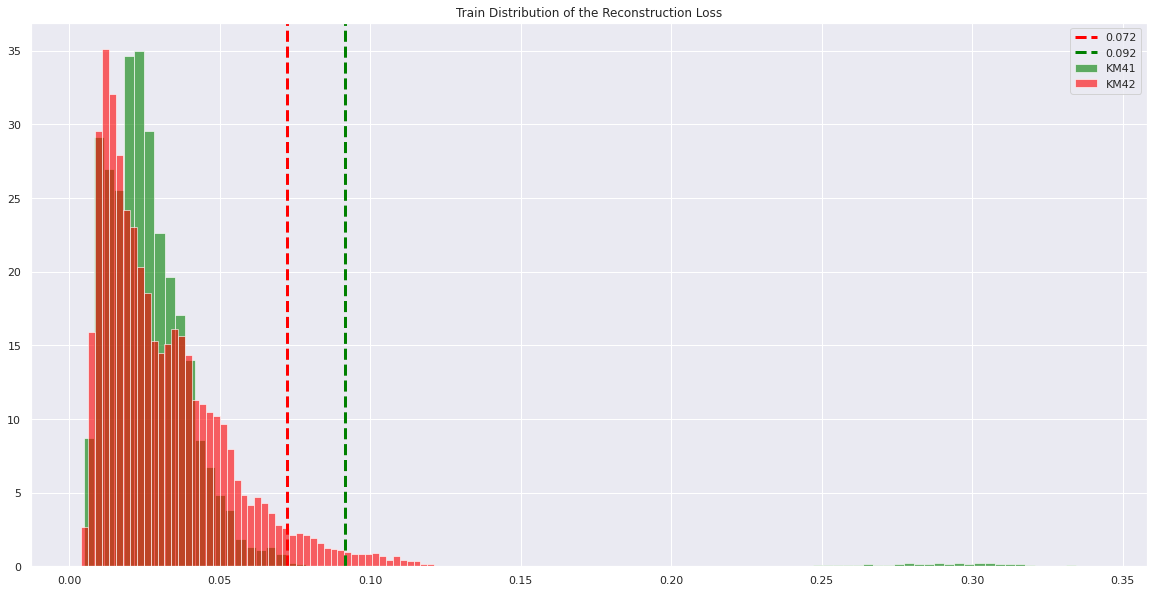

In [14]:
KM41 = train_mae_loss[train['Machine_KM41'] == 1]
KM42 = train_mae_loss[train['Machine_KM42'] == 1]

fig, ax = plt.subplots(figsize=(20,10))

ax.hist(KM41, bins=100, density=True, label="KM41", alpha=.6, color="green")
ax.hist(KM42, bins=100, density=True, label="KM42", alpha=.6, color="red")
plt.axvline(threshold_KM42, color='red', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold_KM42))
plt.axvline(threshold_KM41, color='green', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold_KM41))

plt.title("Train Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

In [15]:
# pal0 = train_mae_loss[train['PALIER EN COURS C2_0.0'] == 1]
# pal1 = train_mae_loss[train['PALIER EN COURS C2_1.0'] == 1]
# pal2 = train_mae_loss[train['PALIER EN COURS C2_2.0'] == 1]
# pal3 = train_mae_loss[train['PALIER EN COURS C2_3.0'] == 1]
# pal4 = train_mae_loss[train['PALIER EN COURS C2_4.0'] == 1]
# pal5 = train_mae_loss[train['PALIER EN COURS C2_5.0'] == 1]
# pal6 = train_mae_loss[train['PALIER EN COURS C2_6.0'] == 1]
# pal7 = train_mae_loss[train['PALIER EN COURS C2_7.0'] == 1]
# pal8 = train_mae_loss[train['PALIER EN COURS C2_8.0'] == 1]
# pal9 = train_mae_loss[train['PALIER EN COURS C2_9.0'] == 1]


# fig, ax = plt.subplots(figsize=(20,10))

# ax.hist(pal0, bins=50, density=True, label="Palier 0", alpha=.6)
# ax.hist(pal1, bins=30, density=True, label="Palier 1", alpha=.6)
# ax.hist(pal2, bins=30, density=True, label="Palier 2", alpha=.6)
# ax.hist(pal3, bins=30, density=True, label="Palier 3", alpha=.6)
# ax.hist(pal4, bins=30, density=True, label="Palier 4", alpha=.6)
# ax.hist(pal5, bins=50, density=True, label="Palier 5", alpha=.6)
# ax.hist(pal6, bins=30, density=True, label="Palier 6", alpha=.6)
# ax.hist(pal7, bins=50, density=True, label="Palier 7", alpha=.6)
# ax.hist(pal8, bins=50, density=True, label="Palier 8", alpha=.6)
# ax.hist(pal9, bins=50, density=True, label="Palier 9", alpha=.6)
# plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))

# plt.title("(Normalized) Distribution of the Reconstruction Loss")
# plt.legend()
# plt.show()

### Testing Results

In [16]:
reconstructions = model.predict(test_scaled)
test_mae_loss = np.mean(np.abs(reconstructions - test_scaled), axis=1)

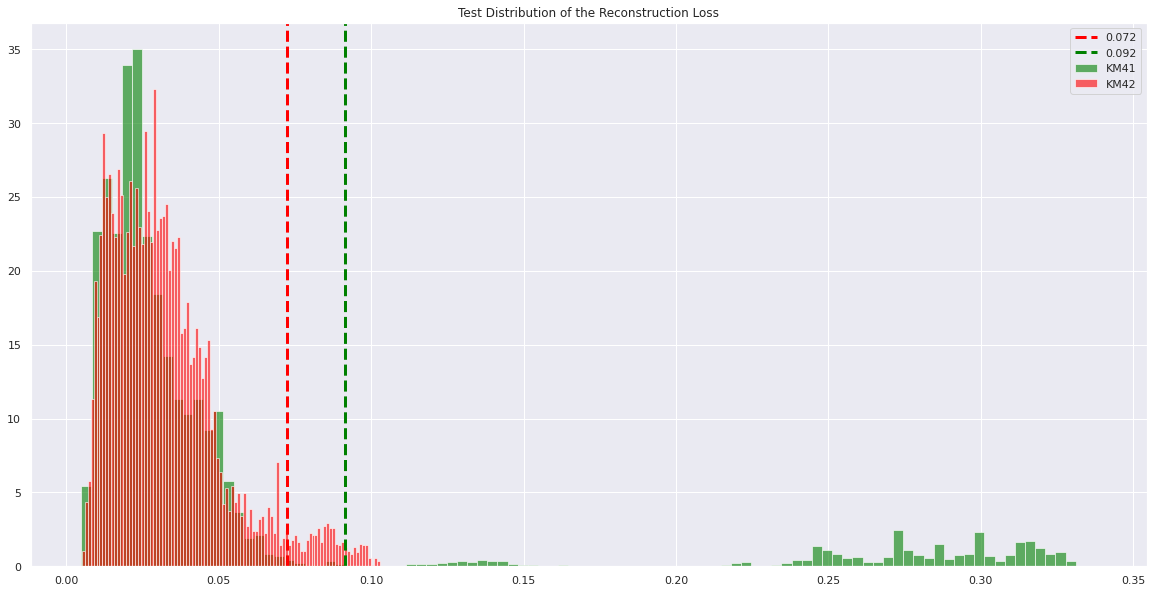

In [17]:
KM41 = test_mae_loss[test['Machine_KM41'] == 1]
KM42 = test_mae_loss[test['Machine_KM42'] == 1]

fig, ax = plt.subplots(figsize=(20,10))

ax.hist(KM41, bins=100, density=True, label="KM41", alpha=.6, color="green")
ax.hist(KM42, bins=100, density=True, label="KM42", alpha=.6, color="red")
plt.axvline(threshold_KM42, color='red', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold_KM42))
plt.axvline(threshold_KM41, color='green', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold_KM41))

plt.title("Test Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

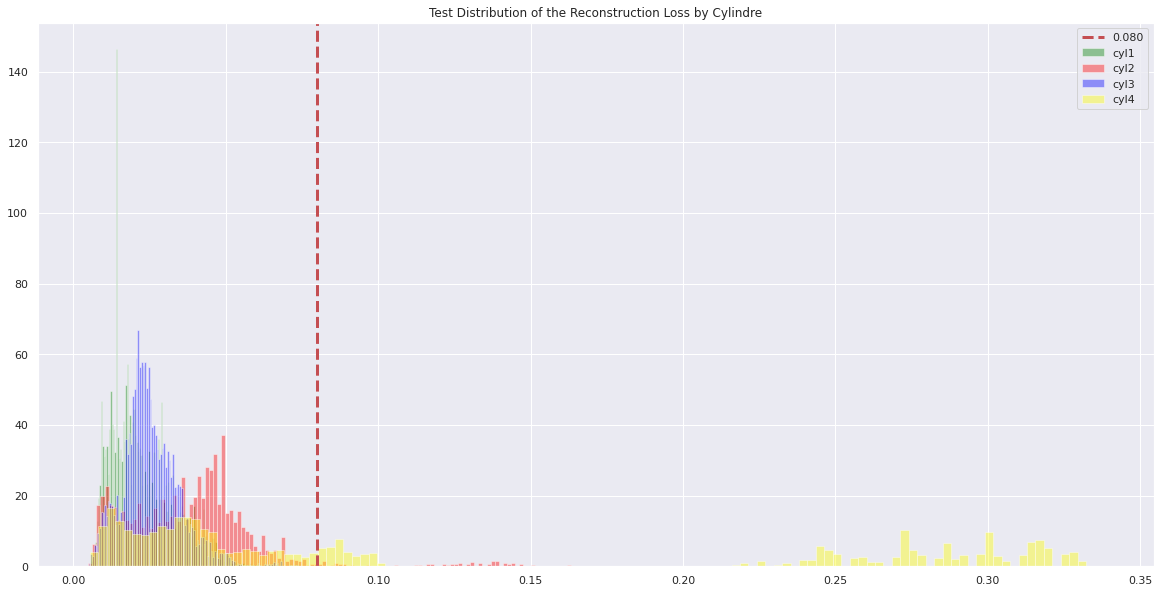

In [18]:
cyl1 = test_mae_loss[test['variable_VIBRATIONS CYLINDRES 1 CPC2'] == 1]
cyl2 = test_mae_loss[test['variable_VIBRATIONS CYLINDRES 2 CPC2'] == 1]
cyl3 = test_mae_loss[test['variable_VIBRATIONS CYLINDRES 3 CPC2'] == 1]
cyl4 = test_mae_loss[test['variable_VIBRATIONS CYLINDRES 4 CPC2'] == 1]

fig, ax = plt.subplots(figsize=(20,10))

ax.hist(cyl1, bins=120, density=True, label="cyl1", alpha=.4, color="green")
ax.hist(cyl2, bins=120, density=True, label="cyl2", alpha=.4, color="red")
ax.hist(cyl3, bins=120, density=True, label="cyl3", alpha=.4, color="blue")
ax.hist(cyl4, bins=120, density=True, label="cyl4", alpha=.4, color="yellow")
plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))

plt.title("Test Distribution of the Reconstruction Loss by Cylindre")
plt.legend()
plt.show()

In [19]:
# pal0 = test_mae_loss[test['PALIER EN COURS C2_0.0'] == 1]
# pal1 = test_mae_loss[test['PALIER EN COURS C2_1.0'] == 1]
# pal2 = test_mae_loss[test['PALIER EN COURS C2_2.0'] == 1]
# pal3 = test_mae_loss[test['PALIER EN COURS C2_3.0'] == 1]
# pal4 = test_mae_loss[test['PALIER EN COURS C2_4.0'] == 1]
# pal5 = test_mae_loss[test['PALIER EN COURS C2_5.0'] == 1]
# pal6 = test_mae_loss[test['PALIER EN COURS C2_6.0'] == 1]
# pal7 = test_mae_loss[test['PALIER EN COURS C2_7.0'] == 1]
# pal8 = test_mae_loss[test['PALIER EN COURS C2_8.0'] == 1]
# pal9 = test_mae_loss[test['PALIER EN COURS C2_9.0'] == 1]


# fig, ax = plt.subplots(figsize=(20,10))

# ax.hist(pal0, bins=30, density=True, label="Palier 0", alpha=.6)
# ax.hist(pal1, bins=30, density=True, label="Palier 1", alpha=.6)
# ax.hist(pal2, bins=30, density=True, label="Palier 2", alpha=.6)
# ax.hist(pal3, bins=30, density=True, label="Palier 3", alpha=.6)
# ax.hist(pal4, bins=30, density=True, label="Palier 4", alpha=.6)
# ax.hist(pal5, bins=30, density=True, label="Palier 5", alpha=.6)
# ax.hist(pal6, bins=30, density=True, label="Palier 6", alpha=.6)
# ax.hist(pal7, bins=30, density=True, label="Palier 7", alpha=.6)
# ax.hist(pal8, bins=30, density=True, label="Palier 8", alpha=.6)
# ax.hist(pal9, bins=30, density=True, label="Palier 9", alpha=.6)
# plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))

# plt.title("(Normalized) Distribution of the Reconstruction Loss")
# plt.legend()
# plt.show()

## Visualisation of the anomalies

In [20]:
test.loc[test['Machine_KM41'] == 1, 'Threshold'] = threshold_KM41
test.loc[test['Machine_KM41'] == 0, 'Threshold'] = threshold_KM42
test['Loss'] = test_mae_loss
test.loc[test['Loss'] <= test['Threshold'], 'Anomaly'] = "Normal"
test.loc[test['Loss'] >= test['Threshold'], 'Anomaly'] = "Anomaly"
test.head(3)

,value,value_lag1,value_lag2,value_lag3,variable_VIBRATIONS CYLINDRES 1 CPC2,variable_VIBRATIONS CYLINDRES 2 CPC2,variable_VIBRATIONS CYLINDRES 3 CPC2,variable_VIBRATIONS CYLINDRES 4 CPC2,Machine_KM41,Machine_KM42,Threshold,Loss,Anomaly
Date,,,,,,,,,,,,,
2022-07-01 00:04:28+00:00,9.0,9.973927,9.321691,9.787036,1,0,0,0,1,0,0.091508,0.030241,Normal
2022-07-01 00:04:28+00:00,10.0,10.993885,13.000000,11.271657,0,1,0,0,1,0,0.091508,0.021115,Normal
2022-07-01 00:04:28+00:00,11.0,11.000000,11.000000,11.000000,0,0,0,1,1,0,0.091508,0.313705,Anomaly


## KM42 visualisation par étages

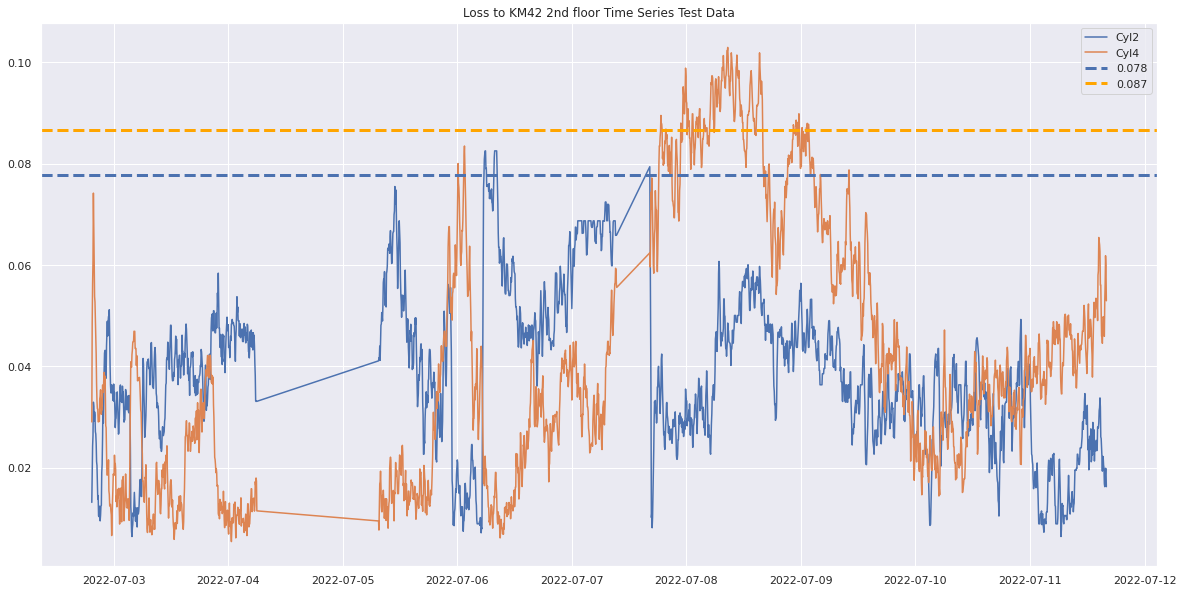

In [21]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(test['Loss'][(test['Machine_KM41'] == 0) & (test['variable_VIBRATIONS CYLINDRES 2 CPC2'] == 1)], label='Cyl2')
ax.plot(test['Loss'][(test['Machine_KM41'] == 0) & (test['variable_VIBRATIONS CYLINDRES 4 CPC2'] == 1)], label='Cyl4')
plt.axhline(threshold_KM42_cyl2, color='b', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold_KM42_cyl2))
plt.axhline(threshold_KM42_cyl4, color='orange', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold_KM42_cyl4))

plt.title("Loss to KM42 2nd floor Time Series Test Data")
plt.legend()
plt.show()

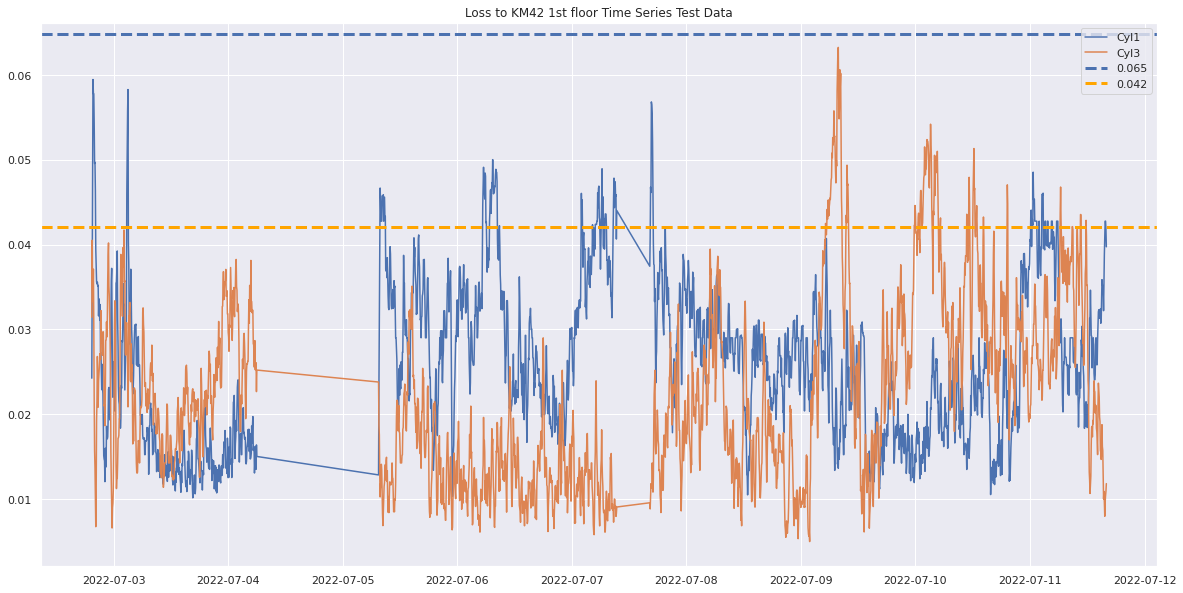

In [22]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(test['Loss'][(test['Machine_KM41'] == 0) & (test['variable_VIBRATIONS CYLINDRES 1 CPC2'] == 1)], label="Cyl1")
ax.plot(test['Loss'][(test['Machine_KM41'] == 0) & (test['variable_VIBRATIONS CYLINDRES 3 CPC2'] == 1)], label='Cyl3')
plt.axhline(threshold_KM42_cyl1, color='b', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold_KM42_cyl1))
plt.axhline(threshold_KM42_cyl3, color='orange', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold_KM42_cyl3))

plt.title("Loss to KM42 1st floor Time Series Test Data")
plt.legend()
plt.show()

## KM41 Visualisation par étages

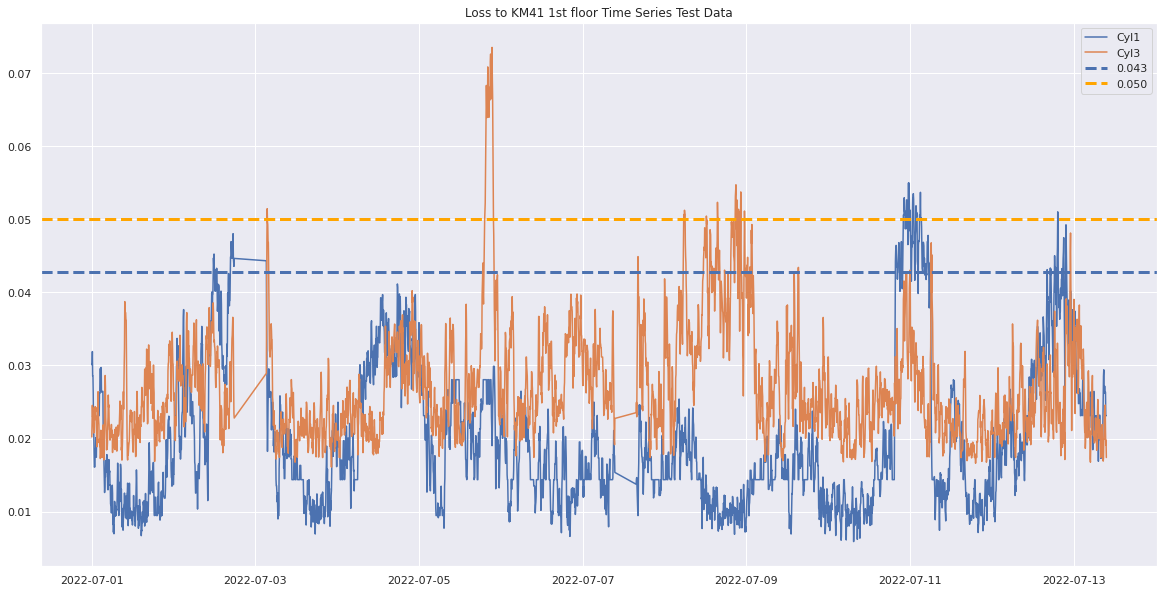

In [23]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(test['Loss'][(test['Machine_KM41'] == 1) & (test['variable_VIBRATIONS CYLINDRES 1 CPC2'] == 1)], label='Cyl1')
ax.plot(test['Loss'][(test['Machine_KM41'] == 1) & (test['variable_VIBRATIONS CYLINDRES 3 CPC2'] == 1)], label='Cyl3')
plt.axhline(threshold_KM41_cyl1, color='b', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold_KM41_cyl1))
plt.axhline(threshold_KM41_cyl3, color='orange', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold_KM41_cyl3))

plt.title("Loss to KM41 1st floor Time Series Test Data")
plt.legend()
plt.show()

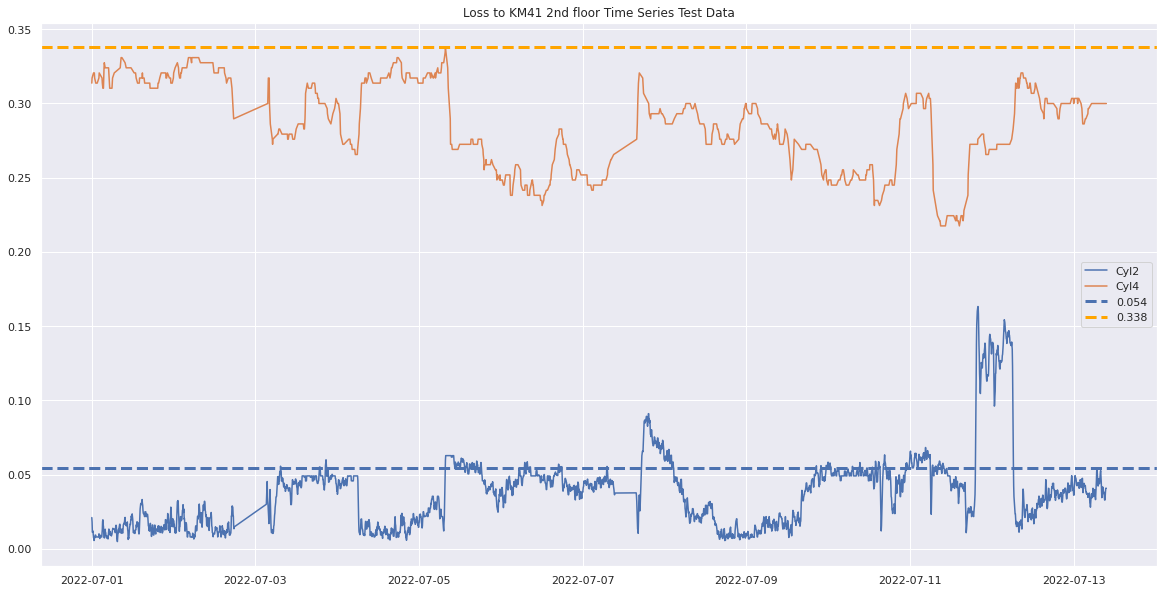

In [24]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(test['Loss'][(test['Machine_KM41'] == 1) & (test['variable_VIBRATIONS CYLINDRES 2 CPC2'] == 1)], label='Cyl2')
ax.plot(test['Loss'][(test['Machine_KM41'] == 1) & (test['variable_VIBRATIONS CYLINDRES 4 CPC2'] == 1)], label='Cyl4')
plt.axhline(threshold_KM41_cyl2, color='b', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold_KM41_cyl2))
plt.axhline(threshold_KM41_cyl4, color='orange', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold_KM41_cyl4))

plt.title("Loss to KM41 2nd floor Time Series Test Data")
plt.legend()
plt.show()